In [1]:
# Import Necessary Modules

import glob
import matplotlib.pyplot as plt 
from skimage import io
import numpy as np
%matplotlib inline 

In [2]:
#This function reads in all n images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get a data matrix
#X of size n x 4096. We also generate a -1 label if the row vector corresponds
#to a cat image and a +1 label if the row vector corresponds to a dog image
#and stack these on top of one another to get a label vector y of length n.

def read_data():
    
    #get image filenames
    cat_locs = glob.glob('catsfolder/*.jpg')
    dog_locs = glob.glob('dogsfolder/*.jpg')
    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)

    #initialize empty arrays
    X_cats = np.zeros((num_cats,64*64))
    X_dogs = np.zeros((num_dogs,64*64))
    y_cats = np.zeros((num_cats,1))
    y_dogs = np.zeros((num_dogs,1))
               
    #Load data, reshape into a 1D vector and set labels
    
    keep_track = 0

    for i in range(len(cat_locs)):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_cats[i,:] = im
        y_cats[i] = -1.0
        keep_track += 1

    for i in range(len(dog_locs)):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_dogs[i,:] = im
        y_dogs[i] = 1.0
        keep_track += 1
    
    # combine both datasets
    X = np.append(X_cats,X_dogs,0)
    y = np.append(y_cats,y_dogs)
    
    return X, y 

In [3]:
#This function takes in an n x 4096 data matrix X and an index i. It extracts
#the ith row of X and displays it as a grayscale 64 x 64 image.

def show_image(X, i, label):
    #select image
    image = X[i,:]
    #reshape make into a square
    image = image.reshape((64,64))
    #display the image
    plt.title(label)
    plt.imshow(image,'gray')

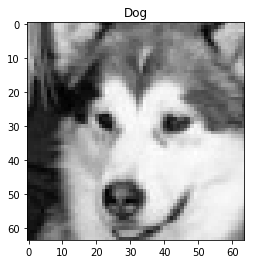

In [4]:
#Test to see if read_data and show_image working
X,y = read_data()
show_image(X,1505, "Dog")

In [5]:
#This function takes in a vector of true labels ytrue
#and a vector of guessed labels yguess and reports back
#the accuracy of the guesses out of 100%.

def calculate_accuracy(ytrue, yguess):
    
    # compare your predictions with the correct labels to determine how many of your predictions were correct.
    correct = sum(ytrue == yguess)
    total = len(ytrue)
    accuracy = 100*float(correct)/float(total)
    # divide the number of correct predictions by the number of total samples to determine your classification accuracy.
    return accuracy

In [6]:
#This function takes in a data matrix X, label vector y, and 
#the desired percentage testpercent. It randomly assigns  
#testpercent of the rows of X and y to Xtest and ytest. 
#The remaining data is assigned to Xtrain and ytrain.

def split_data(X,y,testpercent):
        
    [n, d] = X.shape
    
    ntest = int(round(n*(float(testpercent)/100)))
    ntrain = int(round(n - ntest))
        
    Xtrain = np.zeros((ntrain,d))
    Xtest = np.zeros((ntest,d))
    ytrain = np.zeros((ntrain,1))
    ytest = np.zeros((ntest,1))   
        
    Data = np.column_stack((X,y))
    Data = np.random.permutation(Data)
    
    for i in range(ntest):
        Xtest[i,:] = Data[i,0:d]
        ytest[i] = Data[i,d]
        
    for i in range(ntrain):
        Xtrain[i,:] = Data[i+ntest,0:d]
        ytrain[i] = Data[i+ntest,d]
        
    return Xtrain, ytrain, Xtest, ytest

In [7]:
#This code implements the PCA exactly as in MATLAB so as to be consistent.
#It takes in an n x d data matrix X and returns a d x d orthonormal matrix pcaX. 
#Each column of pcaX contains a basis vector, sorted by decreasing variance.

def pca(X):
    covX = np.cov(X,rowvar=False)
    [Lambda,Vtranspose] = np.linalg.eig(covX)
    neworder = np.argsort(-abs(Lambda))
    pcaX = Vtranspose[:,neworder]
    pcaX = pcaX.real
    return pcaX

In [8]:
#This function takes in a data matrix X and a label
#vector y and outputs the average cat image and average dog image.

def average_pet(X,y):
    
    avgcat, avgdog = np.zeros((1, 4096)), np.zeros((1, 4096))
    catcount, dogcount = 0, 0
    for observation, label in zip(X, y):
        if label == 1:
            avgdog += observation
            dogcount += 1
        elif label == -1:
            avgcat += observation
            catcount += 1
    avgdog = np.divide(avgdog, dogcount)
    avgcat = np.divide(avgcat, catcount)
    
    return avgcat, avgdog

In [9]:
#Using above function to get average cat and average dog arrays.
avgcat, avgdog = average_pet(X, y)

In [10]:
#The "average" cat according to the dataset.
show_image(avgcat, 0)

TypeError: show_image() missing 1 required positional argument: 'label'

In [18]:
#The average dog. How unsettling.
show_image(avgdog, 0)

TypeError: show_image() missing 1 required positional argument: 'label'

In [125]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to whether
#each row of Xtest is closer to the average cat or average dog.

def closest_average(Xtrain,ytrain,Xrun):
    
    yguess = np.zeros((len(Xrun), 1))
    avgcat, avgdog = np.zeros(4096), np.zeros(4096)
    catcount, dogcount = 0, 0
    for observation, label in zip(Xtrain, ytrain):
        if label == 1:
            avgdog += observation
            dogcount += 1
        elif label == -1:
            avgcat += observation
            catcount += 1
    avgdog = np.divide(avgdog, dogcount)
    avgcat = np.divide(avgcat, catcount)
    for index, observation in enumerate(Xrun):
        if np.linalg.norm(observation - avgcat) <= np.linalg.norm(observation - avgdog):
            yguess[index] = -1
        elif np.linalg.norm(observation - avgcat) > np.linalg.norm(observation - avgdog):
            yguess[index] = 1
    
    return yguess

In [141]:
#Using closest average function to classify 30% of test data.
Xtrain, ytrain, Xtest, ytest = split_data(X, y, 30)
yguess = closest_average(Xtrain, ytrain, Xtest)
print("Accuracy: ", calculate_accuracy(ytest, yguess), "%")

Accuracy:  77.83333333333333 %


In [135]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess. Each guess is found
#by searching through Xtrain to find the closest row, and then 
#outputting its label.

def nearest_neighbor(Xtrain,ytrain,Xrun):
    
    yguess = np.zeros((len(Xrun), 1))
    for i, testdata in enumerate(Xrun):
        distance = 99999999
        for observation, label in zip(Xtrain, ytrain):
            if np.linalg.norm(testdata - observation) < distance:
                yguess[i] = label
                distance = np.linalg.norm(testdata - observation)
    
    return yguess

In [142]:
#Using nearest neighbor function to classify 30% of test data. Warning: it is kind of slow. Generally higher accuracy.
yguess = nearest_neighbor(Xtrain, ytrain, Xtest)
print("Accuracy: ", calculate_accuracy(ytest, yguess), "%")

Accuracy:  82.83333333333333 %


In [218]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute ordinary-least-squares
#vector b. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to the sign
#of the linear prediction.

def linear_regression(Xtrain,ytrain,Xrun):
    
    x_t = np.transpose(Xtrain)
    b = (np.linalg.pinv(x_t.dot(Xtrain))).dot(x_t).dot(ytrain)
    yguess = np.sign(Xrun.dot(b))
    
    return yguess

In [220]:
#Uses linear_regression to generate yguess. Pretty good.
yguess = linear_regression(Xtrain, ytrain, Xtest)
print("Accuracy: ", calculate_accuracy(ytest, yguess), "%")

Accuracy:  80.16666666666667 %


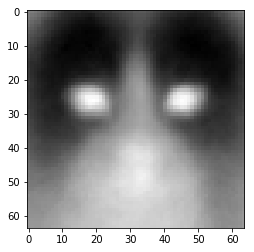

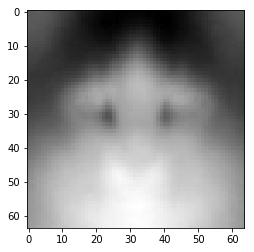

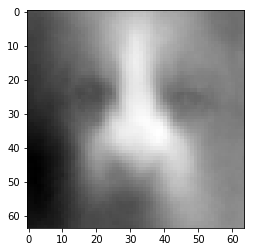

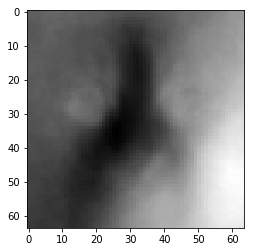

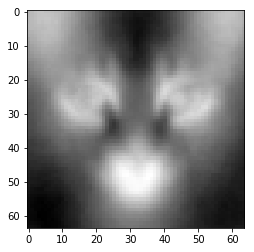

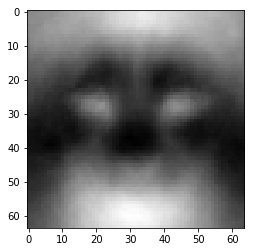

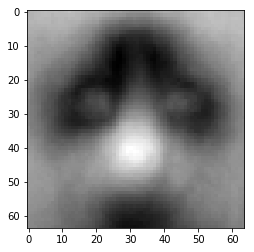

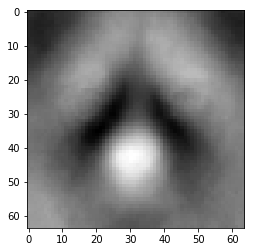

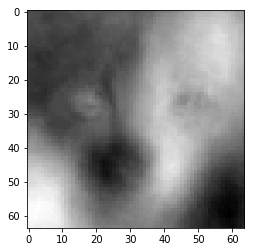

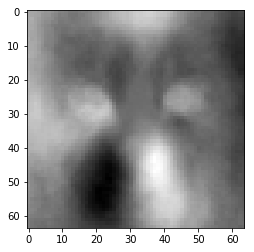

<Figure size 432x288 with 0 Axes>

In [227]:
pcaX = pca(Xtrain)
for i in range(10):
    show_image(np.transpose(pcaX), i)
    plt.figure()

In [294]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the PCA basis. 
#It also takes in a data matrix Xrun and a dimension k
#and uses the top-k vectors in the PCA basis to reduce the 
#dimension of Xtrain and Xrun. Finally, it uses the reduced data
#as inputs to the linear_regression function to produce 
#a vector of label guesses yguess.

def pca_regression(Xtrain,ytrain,Xrun,k):
    
    pcaX = pca(Xtrain)
    pcaX_test = pca(Xtest)
    
    pcaX = np.transpose(pcaX)
    v_k = pcaX[0:k]
    v_k = np.transpose(v_k)
    e_n = np.ones((len(Xtrain), 1))
    x_t = np.transpose(Xtrain).dot(e_n)
    x_t = np.divide(x_t, len(Xtrain))
    x_tc = Xtrain - (e_n.dot(np.transpose(x_t)))
    x_treduced = x_tc.dot(v_k)
    
    pcaX_test = np.transpose(pcaX_test)
    v_kt = pcaX_test[0:k]
    v_kt = np.transpose(v_kt)
    e_nt = np.ones((len(Xrun), 1))
    x_tt = np.transpose(Xrun).dot(e_nt)
    x_tt = np.divide(x_tt, len(Xrun))
    x_c = Xrun - (e_nt.dot(np.transpose(x_tt)))
    x_reduced = x_c.dot(v_kt)
    
    yguess = linear_regression(x_treduced, ytrain, x_reduced)

    return yguess

In [296]:
#This takes a while. I recommend altering the arguments so that pca only needs to be run once for each matrix (I would
#have done it but I wasn't sure if I would get full points).
yguess = pca_regression(Xtrain, ytrain, Xtest, 10)
print("Accuracy for k = 10: ", calculate_accuracy(ytest, yguess), "%")

yguess = pca_regression(Xtrain, ytrain, Xtest, 20)
print("Accuracy for k = 20: ", calculate_accuracy(ytest, yguess), "%")

yguess = pca_regression(Xtrain, ytrain, Xtest, 50)
print("Accuracy for k = 50: ", calculate_accuracy(ytest, yguess), "%")

yguess = pca_regression(Xtrain, ytrain, Xtest, 100)
print("Accuracy for k = 100: ", calculate_accuracy(ytest, yguess), "%")

Accuracy for k = 10:  69.16666666666667 %
Accuracy for k = 20:  69.0 %
Accuracy for k = 50:  64.5 %
Accuracy for k = 100:  64.5 %


In [11]:
#Competition
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

X,y = read_data()
Xtrain, ytrain, Xtest, ytest = split_data(X, y, 30)

class animalsDataset(Dataset):

    def __init__(self, X, y): 
        X_ = torch.tensor(X)
        self.X = torch.zeros(len(X), 1, 64, 64, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.int64)
        for k, i in enumerate(X_):
            new_i = i[np.newaxis, np.newaxis, :]
            new_i.resize_(1, 64, 64)
            self.X[k] = new_i
        self.X = self.X / 1000
        for k, i in enumerate(self.y):
            if i == -1:
                self.y[k] = 0
            elif i == 1:
                self.y[k] = 1
        self.y = self.y.clone().detach().squeeze()
            
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        sample = tuple((self.X[index], self.y[index]))

        return sample

In [12]:
trainData = animalsDataset(Xtrain, ytrain)
testData = animalsDataset(Xtest, ytest)


In [13]:
torch.manual_seed(1)

class Net(nn.Module):
    
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))
            else:
                activation = linear_transform(activation)
                activation = F.softmax(activation, dim = 1)
        return activation
    
class CNN(nn.Module):
    
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn0 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size = 4, stride=1, padding=1)
        self.conv0_bn = nn.BatchNorm2d(8)
        self.relu0 = nn.ReLU()
        self.maxpool0 = nn.MaxPool2d(kernel_size=2)
        self.cnn1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(1568, 2)
    
    # Prediction
    def forward(self, x):
        out = self.cnn0(x)
        out = self.conv0_bn(out)
        out = self.relu0(out)
        out = self.maxpool0(out)
        out = self.cnn1(out)
        out = self.conv1_bn(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.conv2_bn(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.softmax(out, dim = 1)
        return out
    
'''
model=nn.Sequential(
    nn.Linear(4096, 100),
    nn.ReLU(),
    nn.Linear(100, 2),
    nn.Softmax(dim = 1))
'''


#model = Net([4096, 1000, 1000, 100, 2])
model = CNN()

In [14]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=trainData, batch_size=10)
validation_loader = torch.utils.data.DataLoader(dataset=testData, batch_size=1)

In [15]:
n_epochs = 10
loss_list = []
accuracy_list = []
N_train = len(trainData)
N_validate = len(testData)

def train_model(n_epochs):
    for i, epoch in enumerate(range(n_epochs)):
        print("Epoch " + str(i + 1))
        correct = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x) #z = model(x.view(-1, 64 * 64))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
        accuracy = correct / N_train
        print("Training accuracy: ", accuracy * 100, "%")

        
        correct=0  
        for x_test, y_test in validation_loader:
            z = model(x_test) #z = model(x_test.view(-1, 64 * 64))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_validate
        accuracy_list.append(accuracy)
        loss_list.append(loss.data)
        print("Validation accuracy: ", round(accuracy * 100, 2), "%")
        print()
        
    return accuracy


In [16]:
accuracy = train_model(n_epochs)
print("Final accuracy: ", round(accuracy * 100, 2), "%")

Epoch 1
Training accuracy:  87.5 %
Validation accuracy:  95.5 %

Epoch 2
Training accuracy:  95.92857142857143 %
Validation accuracy:  96.5 %

Epoch 3
Training accuracy:  97.5 %
Validation accuracy:  97.0 %

Epoch 4
Training accuracy:  98.21428571428571 %
Validation accuracy:  97.17 %

Epoch 5
Training accuracy:  98.57142857142858 %
Validation accuracy:  97.33 %

Epoch 6
Training accuracy:  99.0 %
Validation accuracy:  97.5 %

Epoch 7
Training accuracy:  99.21428571428571 %
Validation accuracy:  97.5 %

Epoch 8
Training accuracy:  99.28571428571429 %
Validation accuracy:  97.5 %

Epoch 9
Training accuracy:  99.64285714285714 %
Validation accuracy:  97.5 %

Epoch 10
Training accuracy:  99.64285714285714 %
Validation accuracy:  97.83 %

Final accuracy:  97.83 %


Accuracy:  98.55 %


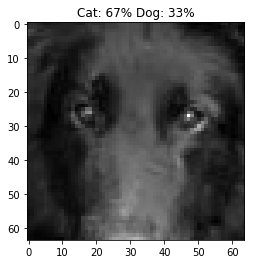

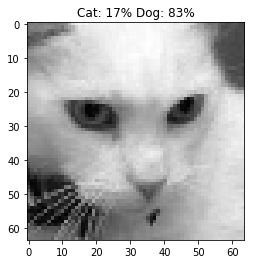

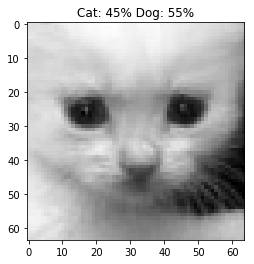

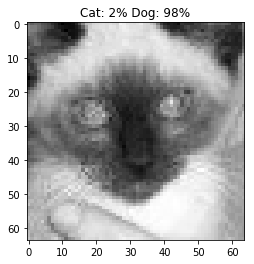

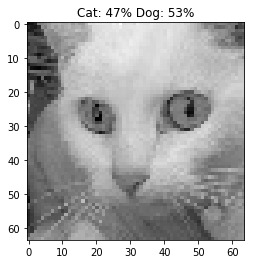

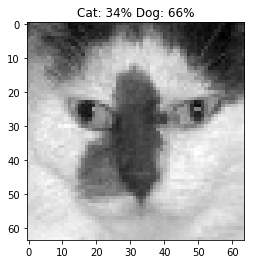

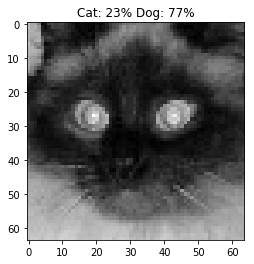

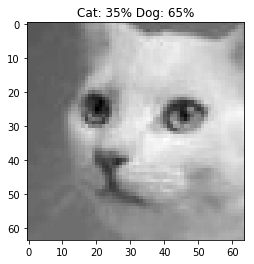

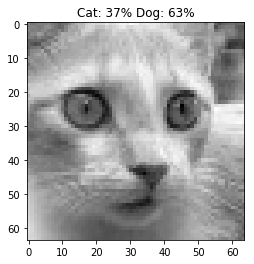

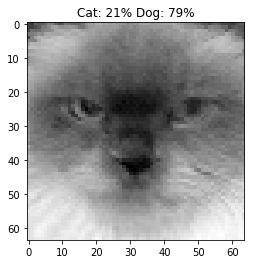

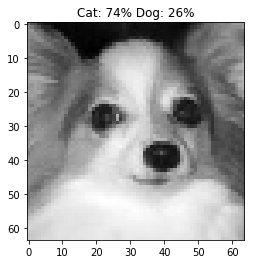

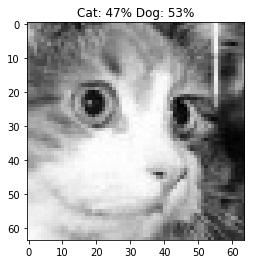

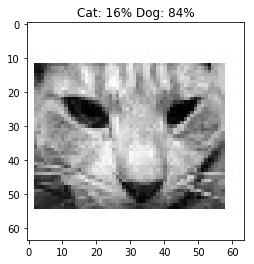

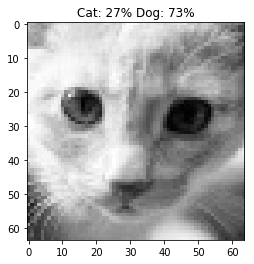

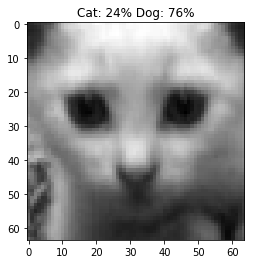

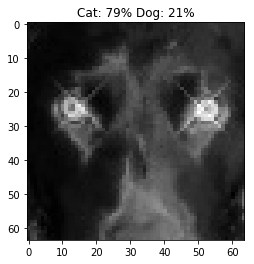

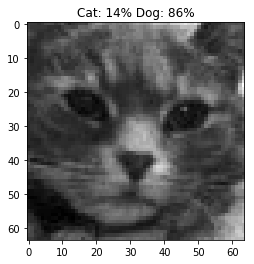

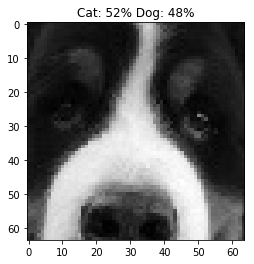

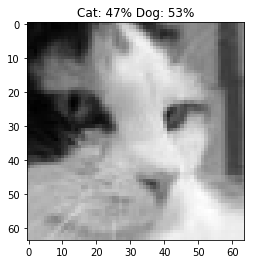

<Figure size 432x288 with 0 Axes>

In [34]:
#To run test on pre-trained model, run what is below. The only modification that must be made is changing the
#directories in read_data (or simply name the test directories as outlined in read_data()) so that X, y correspond 
#to the correct test data.


X, y = read_data()
Xtrain, ytrain, Xtest, ytest = split_data(X, y, 100)
testDataset = animalsDataset(Xtest, ytest)
final_loader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=1)
yguess = np.zeros(len(ytest))
shown = 0
for i, (observation, label) in enumerate(final_loader):
    z = model(observation)
    _, yhat = torch.max(z.data, 1)
    yhat = yhat.item()
    if yhat == 0:
        guess = -1
        yguess[i] = guess
    elif yhat == 1:
        guess = 1
        yguess[i] = guess
    if(shown < 19 and guess != ytest[i]):
        label = "Cat: " + str(round(z[0][0].item() * 100)) + "% Dog: " + str(round(z[0][1].item() * 100)) + "%" 
        show_image(Xtest, i, label = label)
        plt.figure()
        shown += 1

ytest = np.reshape(ytest, 2000)

print("Accuracy: ", calculate_accuracy(ytest, yguess), "%")